# This project will build a model to automatically classify 100 plant species using features extracted from their leaf images.

In [231]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_highcharts.display import display_charts
from skimage import feature, io, morphology, measure, img_as_uint, filters
from skimage.transform import rescale, resize
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA, KernelPCA
from sklearn.preprocessing import LabelEncoder, scale

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### There are pre-extracted plant features stored in three files.

In [3]:
#A function to read the files and show basic information.
f_loc = 'species100/'
def file_input(file,prefix,n_cols):
    df = pd.read_csv(f_loc+file, header=None, names=[prefix+str(i) for i in range(n_cols)])
    print('(rows, columns): ',df.shape)
    print(df.head(2))
    print('Amount of Null Values: ',df.isnull().sum().sum())
    return df

In [4]:
#read the files
df_sha = file_input('data_Sha_64.txt','sha',65)

(rows, columns):  (1600, 65)
              sha0      sha1      sha2      sha3      sha4      sha5  \
0  Acer Capillipes  0.000579  0.000609  0.000551  0.000554  0.000603   
1  Acer Capillipes  0.000630  0.000661  0.000719  0.000651  0.000643   

       sha6      sha7      sha8      sha9    ...        sha55     sha56  \
0  0.000614  0.000611  0.000611  0.000611    ...     0.000507  0.000533   
1  0.000640  0.000646  0.000624  0.000584    ...     0.000503  0.000520   

      sha57     sha58     sha59     sha60     sha61     sha62     sha63  \
0  0.000555  0.000565  0.000581  0.000597  0.000625  0.000624  0.000617   
1  0.000533  0.000564  0.000596  0.000623  0.000642  0.000661  0.000671   

      sha64  
0  0.000614  
1  0.000667  

[2 rows x 65 columns]
Amount of Null Values:  0


In [5]:
df_mar = file_input('data_Mar_64.txt','mar',65)

(rows, columns):  (1600, 65)
             mar0      mar1      mar2      mar3      mar4      mar5      mar6  \
0  Acer Campestre  0.003906  0.003906  0.027344  0.033203  0.007812  0.017578   
1  Acer Campestre  0.005859  0.013672  0.027344  0.025391  0.013672  0.029297   

       mar7      mar8      mar9  ...       mar55  mar56     mar57     mar58  \
0  0.023438  0.005859  0.000000  ...    0.011719    0.0  0.005859  0.035156   
1  0.019531  0.000000  0.001953  ...    0.017578    0.0  0.021484  0.017578   

      mar59     mar60     mar61     mar62     mar63  mar64  
0  0.027344  0.033203  0.001953  0.000000  0.017578    0.0  
1  0.046875  0.005859  0.003906  0.003906  0.046875    0.0  

[2 rows x 65 columns]
Amount of Null Values:  0


In [6]:
df_tex = file_input('data_Tex_64.txt','tex',65)

(rows, columns):  (1599, 65)
             tex0      tex1      tex2      tex3      tex4      tex5  tex6  \
0  Acer Campestre  0.025391  0.012695  0.003906  0.004883  0.039062   0.0   
1  Acer Campestre  0.004883  0.018555  0.002930  0.000000  0.069336   0.0   

       tex7      tex8      tex9    ...        tex55  tex56     tex57  \
0  0.017578  0.035156  0.023438    ...     0.103520    0.0  0.001953   
1  0.013672  0.043945  0.026367    ...     0.070312    0.0  0.017578   

      tex58     tex59  tex60  tex61     tex62  tex63     tex64  
0  0.000977  0.022461    0.0    0.0  0.001953    0.0  0.027344  
1  0.000000  0.004883    0.0    0.0  0.000000    0.0  0.002930  

[2 rows x 65 columns]
Amount of Null Values:  0


### The texture file is one row less than the other two files.

In [7]:
# A function to compare the speices names between the different datasets.
def comp(list_of_datasets):
    comp = pd.DataFrame()
    for df in list_of_datasets:
        comp[df.columns[0]] = df[df.columns[0]].unique()
    diff = comp[comp.apply(lambda x: len(set(x)) != 1, axis=1)]
    print('Different names: ',len(diff))
    print(diff.head(10))

In [8]:
#compare the names.
df_list = [df_sha, df_mar, df_tex]
comp(df_list)

Different names:  99
                    sha0             mar0             tex0
0        Acer Capillipes   Acer Campestre   Acer Campestre
1            Acer Opalus  Acer Capillipes  Acer Capillipes
2            Acer Pictum  Acer Circinatum  Acer Circinatum
3     Alnus Maximowiczii        Acer Mono        Acer Mono
4      Cotinus Coggygria      Acer Opalus      Acer Opalus
5  Populus Grandidentata    Acer Palmatum    Acer Palmatum
6    Arundinaria Simonii      Acer Pictum      Acer Pictum
7   Callicarpa Bodinieri  Acer Platanoids  Acer Platanoids
8      Celtis Koraiensis      Acer Rubrum      Acer Rubrum
9    Cercis Siliquastrum   Acer Rufinerve   Acer Rufinerve


### There are a lot of differences probably because the names are not alphabetically ordered.

In [9]:
# Sort the name columns
for df in df_list:
    df.sort_values(by=[df.columns[0]], axis=0, ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)

#compare the datasets again.
comp(df_list)

Different names:  0
Empty DataFrame
Columns: [sha0, mar0, tex0]
Index: []


### The datasets contain the same 100 plant species. One species in the texture dataset probably has one sample missing. Each species should have 16 samples. 

In [10]:
#Find the minimun number of samples for all species in the texture file.
df_tex.groupby(['tex0'])['tex1'].count().min()

15

In [11]:
#Find out the species that has one sample missing.
df_tex.groupby(['tex0'])['tex1'].count().argmin()

'Acer Campestre'

### I can either fill one row in the texture file or delete one row from the other two files, if I want to combine them. Filling one row is probably better. This would also make data plotting easier. 

In [12]:
#Create a one-row dataframe with NaN values and add it onto df_dex.
fill = pd.DataFrame(index=[0],columns=[df_tex.columns])
df_texf = fill.append(df_tex,ignore_index=True)

In [13]:
df_texf.head(2)

,tex0,tex1,tex2,tex3,tex4,tex5,tex6,tex7,tex8,tex9,...,tex55,tex56,tex57,tex58,tex59,tex60,tex61,tex62,tex63,tex64
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Acer Campestre,0.025391,0.012695,0.003906,0.004883,0.039062,0.0,0.017578,0.035156,0.023438,...,0.10352,0.0,0.001953,0.000977,0.022461,0.0,0.0,0.001953,0.0,0.027344


In [14]:
#Fill in the name.
df_texf.ix[0,'tex0'] = 'Acer Campestre'

#Fill in the mean values of the 15 Acer Campestre samples
for i in range(1,65):
    df_texf.ix[0,'tex'+str(i)] = df_texf.ix[1:15, 'tex'+str(i)].mean()

print('Amnount of null values: ',df_texf.isnull().sum().sum())
print('(rows, columns): ',df_texf.shape)

Amnount of null values:  0
(rows, columns):  (1600, 65)


### Dimension reduction for plotting.

In [15]:
#Use MDS to reduce 64 feature vectors to 2.
mds = MDS(n_components=2, metric=True, 
          n_init=4, max_iter=300, verbose=0, 
          eps=0.001, n_jobs=1, random_state=None, 
          dissimilarity='euclidean')

In [15]:
#Dimension reduction for the datasets.
shape_2d = mds.fit_transform(df_sha.ix[:, 'sha1':'sha64'])
margin_2d = mds.fit_transform(df_mar.ix[:, 'mar1':'mar64'])
texture_2d = mds.fit_transform(df_tex.ix[:, 'tex1':'tex64'])
texture_f2d = mds.fit_transform(df_texf.ix[:, 'tex1':'tex64'])

In [16]:
#Create dataframes for plotting analysis. 
#For the texture data analysis, I will only use the refilled dataset.
sha_plot = df_sha[['sha0']].join(pd.DataFrame(shape_2d, columns=['Shape X','Shape Y']))
mar_plot = df_mar[['mar0']].join(pd.DataFrame(margin_2d, columns=['Margin X','Margin Y']))
texf_plot = df_texf[['tex0']].join(pd.DataFrame(texture_f2d, columns=['Texture X','Texture Y']))
tex_plot = df_tex[['tex0']].join(pd.DataFrame(texture_2d, columns=['Texture X','Texture Y']))

In [17]:
sha_plot.head(2)

,sha0,Shape X,Shape Y
0,Acer Campestre,0.000615,0.001752
1,Acer Campestre,0.000059,0.000414


### Plot the 2-dimension features to see if the plants cluster and can be potentiall seperated from each other.


In [46]:
#Customize a color list.
color_list = ['firebrick','darkorange','darkviolet','royalblue','forestgreen',
          'magenta','aquamarine','palegreen','yellow','grey']

In [47]:
#A function to plot 2-d features in scatter for 10 species in each panel.
def feature_plot(df, n_split):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False, figsize=(25,9))
    for ax, i in zip(axes.flat, range(160,160*11,160)):
        n = 0
        groups = df.ix[i-160:i-1,:].groupby([df.columns[0]])
        for name, g in groups:
            name = name.split(n_split)
            name = name[0][0] + '. ' + name[-1][:3].lower()
            ax.scatter(g[df.columns[1]], g[df.columns[2]], 
                       label=name, s=30, c=color_list[n])
            n = n + 1
        
        ax.legend(loc='best', prop={'size':10}, frameon=False)

    plt.suptitle(df.columns[1]+' '+df.columns[2], fontsize=26)

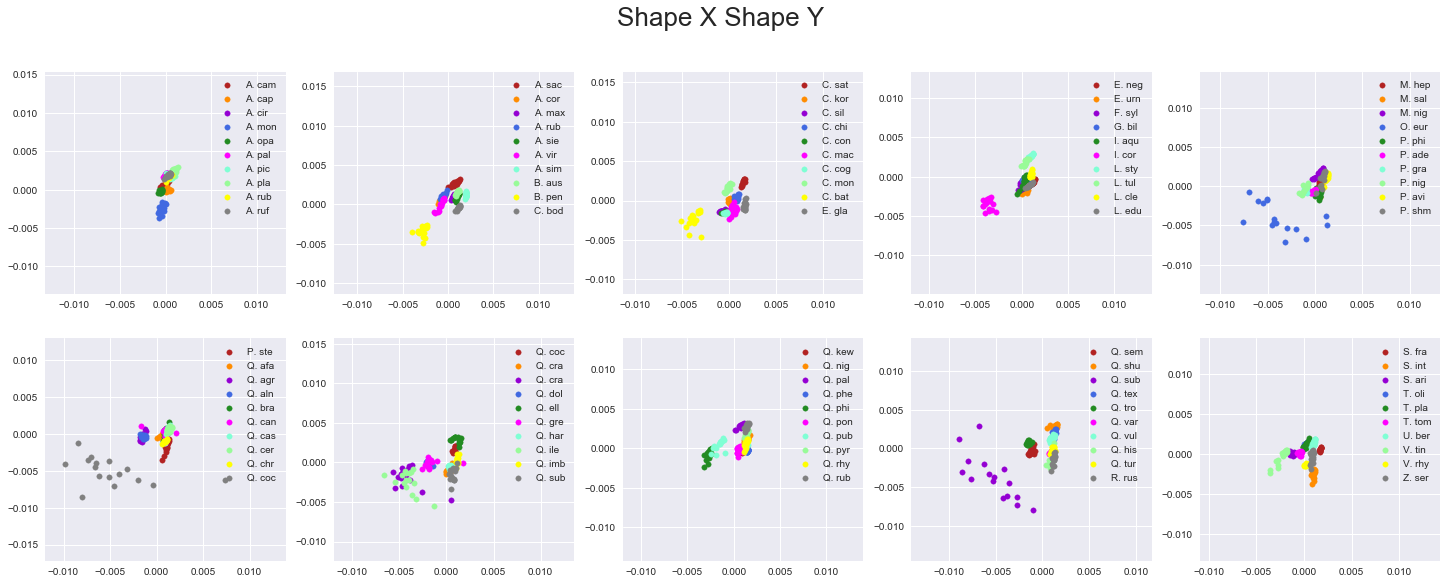

In [20]:
feature_plot(sha_plot, n_split=' ')
plt.show()
plt.close()

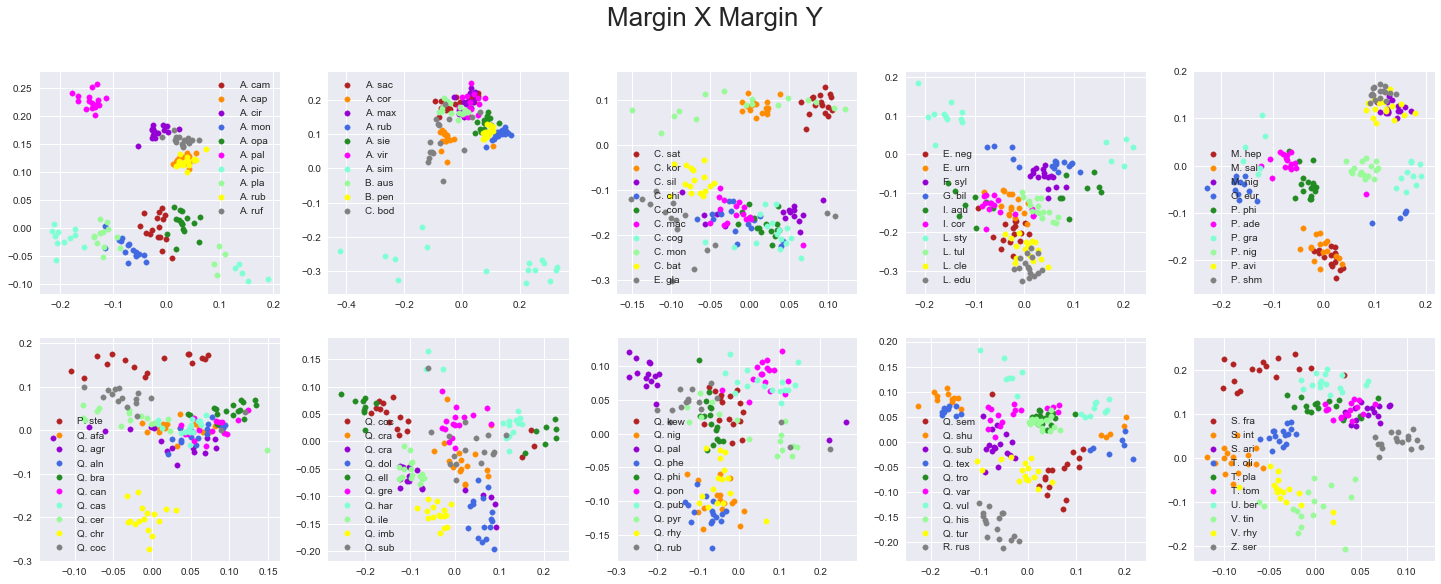

In [21]:
feature_plot(mar_plot, ' ')
plt.show()
plt.close()

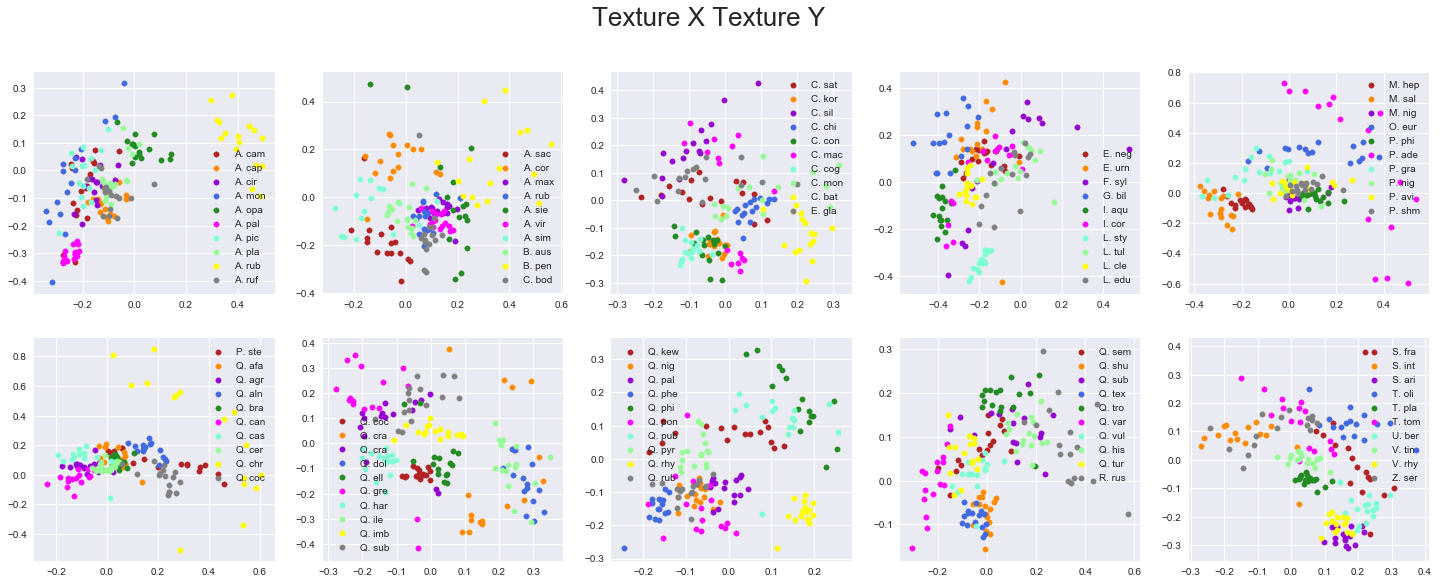

In [22]:
feature_plot(texf_plot, ' ')
plt.show()
plt.close()

### The plant species cluster well by the shape features, while they are more spread out by margin and texture features. The reasonable seperation of the species in the 2 D space suggests that the three pre-extracted features are likely very useful for building algorithms to automatically classify plants. 
### It however may be still difficult to combine three features for classification because the 16 samples of each species are not ordered in the same way between the different feature datasets.

### Use pandas-highcharts to visulize the orginal feature vectors.

In [23]:
#Visulize the mean values of the shape feature vectors of the first 10 species.
display_charts(df_sha.ix[0:159,:].groupby(by=['sha0']).mean(), 
               title="Mean Values of Shape Feature Vectors",
               kind='bar')

In [24]:
#Visulize the mean values of the margin feature vectors of the first 10 species.
display_charts(df_mar.ix[0:159,:].groupby(by=['mar0']).mean(), 
               title="Mean Values of Margin Feature Vectors",
               kind='bar')

In [25]:
#Visulize the mean values of the texture feature vectors of the first 10 species.
display_charts(df_texf.ix[0:159,:].groupby(by=['tex0']).mean(), 
               title="Mean Values of Texture Feature Vectors",
               kind='bar')

### The highcharts suggest that some species have signiture values of the feature vectors. For example, Acer mono is distinct in the shape feature vactors, Acer palmatum is distinct in the margin feature vectors and Acer rubrum is distinct in the texture feature vectors. These species are indeed well seperated in the 2-D feature plots (the first panels).

-----

### To extract features from the original images. There are 16 images for each species and there are 100 species.

### Display the first image for each species.

In [16]:
#A function to get all folders in a specified path.
def collect_folders(path):
    all_list = os.listdir(path)
    folder_list = []
    for item in all_list:
        if os.path.isdir(path+item):
            folder_list.append(item)
    return folder_list

In [17]:
#Collect the folders of the images.
data_root = './species100/data/'
folders = collect_folders(data_root)

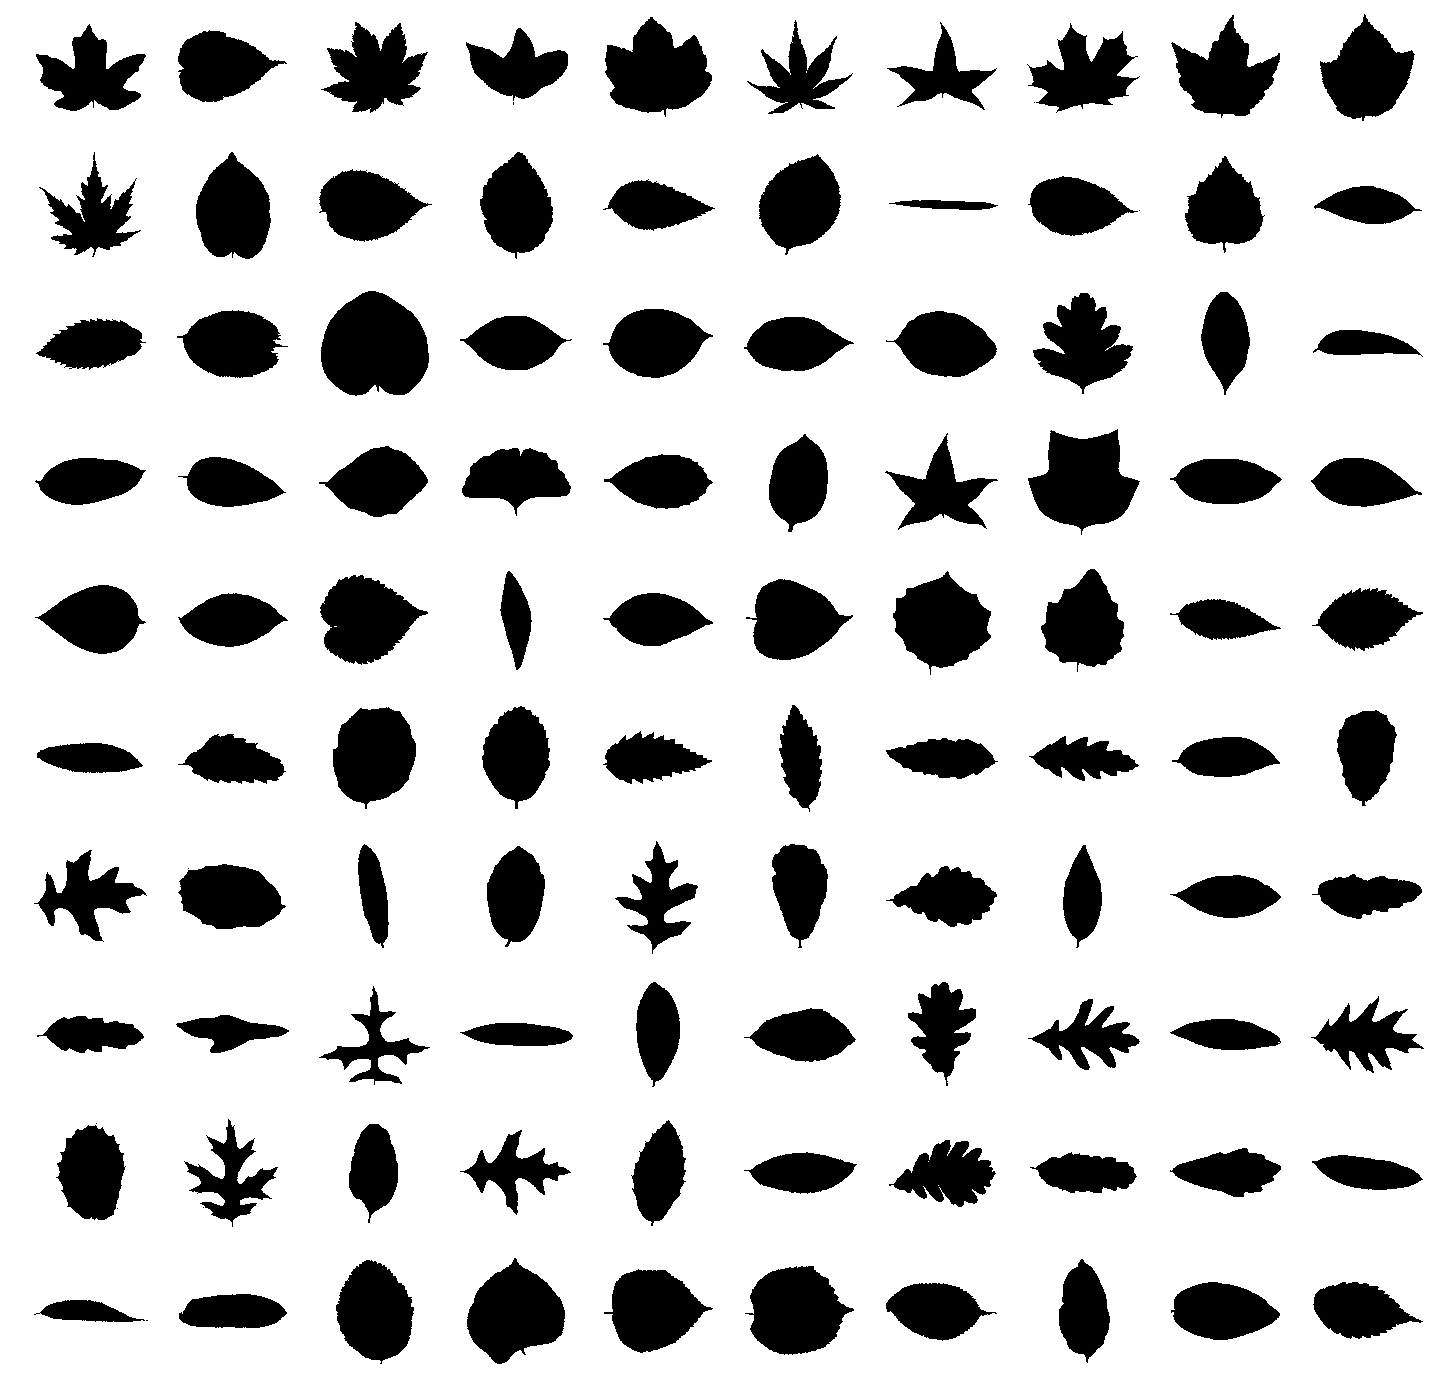

<function matplotlib.pyplot.close>

In [18]:
# Plot the images.
fig, axes = plt.subplots(nrows=10, ncols=10, sharex=False, sharey=False, figsize=(25,25))
for d, ax in zip(folders, axes.flat):
    img = io.imread(data_root+d+'/'+d+'_01.ab.jpg')
    ax.imshow(img)
    ax.grid('off')
    ax.axis('off')
plt.show()
plt.close

### Rescale the images to smaller sizes so that work can be done on my laptop.

In [21]:
#A function to check directory.
def check_dir(path):
    if os.path.exists(path):
        return 'path exists'
    else:
        os.mkdir(path)
        return 'path is newly created.'

In [22]:
#Create a directory for rescaled images.
smalldata_root = './species100/data_small/'
check_dir(smalldata_root)

'path exists'

In [23]:
#Create sub directories for rescaled images.
for d in folders:
    sub_root = smalldata_root+d
    #print(check_dir(sub_root))
    check_dir(sub_root)

In [24]:
#A function to Collect specified type of files in a specified path. 
def collect_fnames(path, file_type):
    all_files = os.listdir(path)
    fnames = []
    for f in all_files:
        if file_type in f:
            fnames.append(f)
    return fnames

In [25]:
io.find_available_plugins(loaded=True)

{'matplotlib': ['imshow', 'imread', 'imshow_collection', 'imread_collection'],
 'pil': ['imread', 'imsave', 'imread_collection']}

In [26]:
#load a plugin
io.use_plugin('pil')

In [27]:
#Rescale the images and save them in new folders

for d in folders:
    for jpg_f in collect_fnames(data_root+d, '.jpg'):
        img_ori = io.imread(data_root+d+'/'+jpg_f)
        img_scaled = rescale(img_ori, 0.1)
        #img_resize = resize(img_scaled, (60,70))
        io.imsave(smalldata_root+d+'/'+jpg_f, img_scaled)

/Applications/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Applications/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [28]:
#get the folders where the small images are stored.
small_folders = collect_folders(smalldata_root)

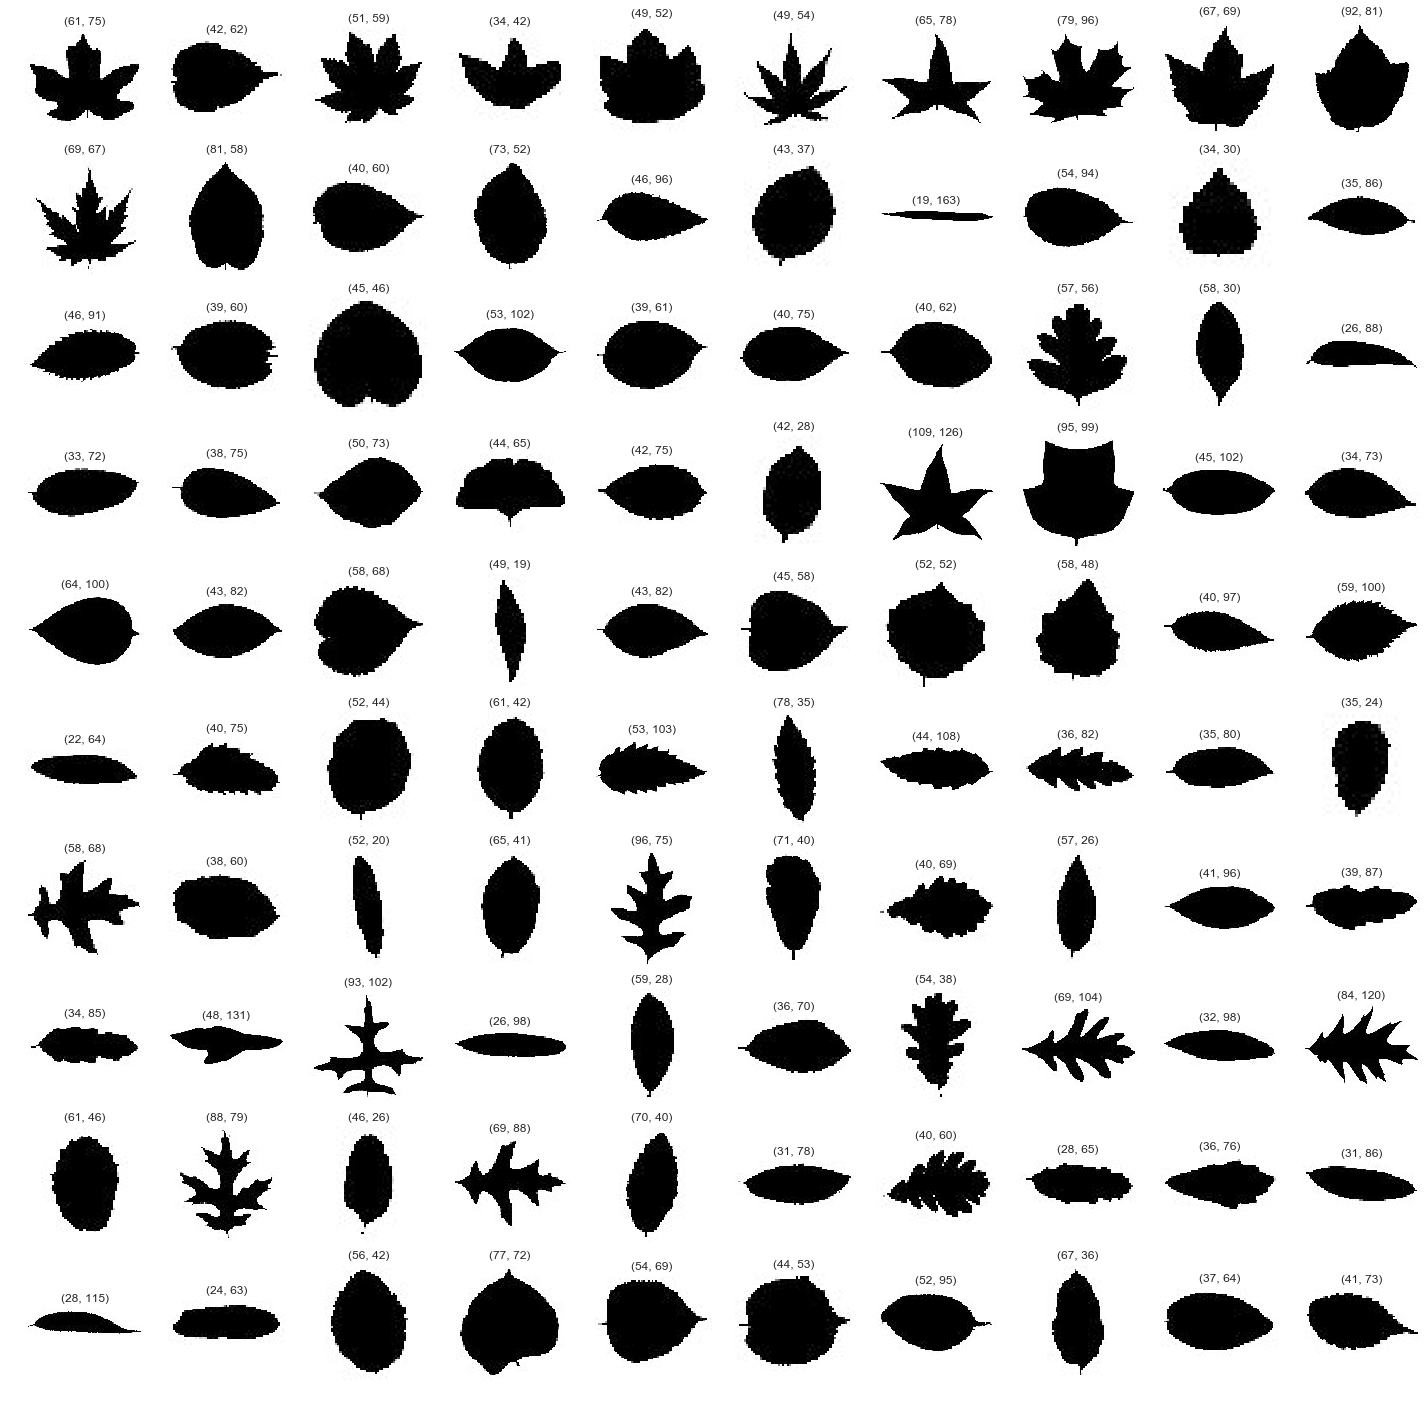

<function matplotlib.pyplot.close>

In [29]:
# Plot the rescaled and resized images.
fig, axes = plt.subplots(nrows=10, ncols=10, sharex=False, sharey=False, figsize=(25,25))
for d, ax in zip(small_folders, axes.flat):
    img = io.imread(smalldata_root+d+'/'+d+'_01.ab.jpg')
    ax.imshow(img)
    ax.set_title(img.shape)
    ax.grid('off')
    ax.axis('off')
plt.show()
plt.close

### Use an image to test feature extraction methods.

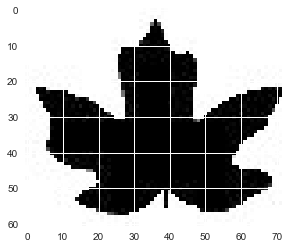

In [206]:
#Display a small image
testim = io.imread(smalldata_root+'Acer_Campestre/Acer_Campestre_01.ab.jpg')
plt.figure(figsize=(5,4))
plt.imshow(testim)
plt.show()
plt.close()

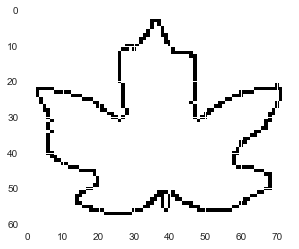

(61, 75)

In [31]:
# Test parameters for extraction of canny edges.
cann_edge = feature.canny(testim, sigma=0.5, 
                          low_threshold=None, high_threshold=None, 
                          mask=None, use_quantiles=False)

plt.figure(figsize=(5,4))
plt.imshow(cann_edge)
plt.show()
plt.close()
cann_edge.shape

In [198]:
#Open and read an image in original size.
img_ori = io.imread(data_root+'Acer_Campestre/Acer_Campestre_01.ab.jpg')

In [199]:
#Extract ORB binary descriptors from the original image.
orb = feature.ORB(downscale=1.2, n_scales=5, n_keypoints=100, 
                  fast_n=9, fast_threshold=0.05, harris_k=0.01)
orb.detect_and_extract(img_ori)
print(orb.descriptors.shape)
orb.descriptors.astype(int)

(100, 256)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 1],
       ..., 
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 1, 1]])

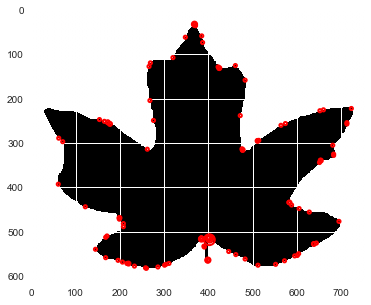

In [208]:
plt.figure(figsize=(6,5))
plt.imshow(img_ori)
plt.scatter(orb.keypoints[:, 1], orb.keypoints[:, 0],
            10 ** orb.scales, facecolors='none', edgecolors='r', linewidth=2)
plt.show()
plt.close()

### 1). Extract canny edges for all small images.

In [38]:
#Create an empty feature list.
cann_edge = []
#Collect jpg files and extract canny edge features
for d in small_folders:
    for jpg_f in collect_fnames(smalldata_root+d, '.jpg'):
        small_image = io.imread(smalldata_root+d+'/'+jpg_f)
        edge_feature = feature.canny(small_image, sigma=0.5, 
                                     low_threshold=None, high_threshold=None, 
                                     mask=None, use_quantiles=False)
        cann_edge.append(np.hstack(([d], edge_feature.astype(int).flat)))

In [39]:
df_cedge = pd.DataFrame(cann_edge, dtype=float, columns=['cedge'+str(i) for i in range(13801)])
df_cedge.shape

(1600, 13801)

In [90]:
df_cedge.head(2)

,cedge0,cedge1,cedge2,cedge3,cedge4,cedge5,cedge6,cedge7,cedge8,cedge9,...,cedge13791,cedge13792,cedge13793,cedge13794,cedge13795,cedge13796,cedge13797,cedge13798,cedge13799,cedge13800
0,Acer_Campestre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Acer_Campestre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
df_cedge.isnull().sum(axis=1).max()

13332

#### There are a lot of NaN values because the images of different species are different in size. Fill in 0 as if they are white space.

In [42]:
df_cedge.fillna(0.0, inplace=True)
df_cedge.isnull().sum().sum()

0

In [43]:
#Dimension reduction for the datasets.
#cedge_2d = mds.fit_transform(df_cedge.ix[:, 'cedge1':'cedge13800'])
# f_ica = FastICA(n_components=2, algorithm='parallel', whiten=True, fun='logcosh', 
#                 fun_args=None, max_iter=200, tol=0.0001, w_init=None, random_state=None)
k_pca = KernelPCA(n_components=2, kernel='poly', gamma=None, degree=4, coef0=1, 
                  kernel_params=None, alpha=1.0, fit_inverse_transform=False, 
                  eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False, 
                  random_state=None, copy_X=True, n_jobs=1)

cedge_2d = k_pca.fit_transform(df_cedge.ix[:, 'cedge1':'cedge13800'])

In [91]:
#Create dataframes for plotting analysis. 
cedge_plot = df_cedge[['cedge0']].join(pd.DataFrame(cedge_2d, columns=['Canny Edge X','Canny Edge Y']))

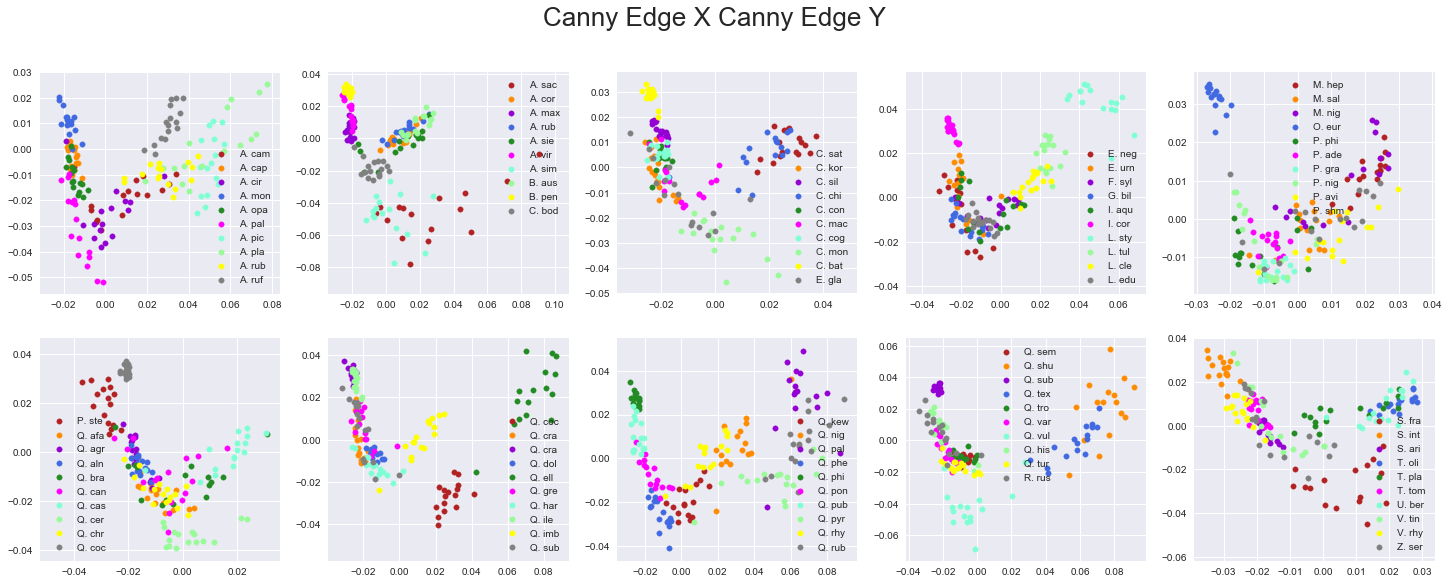

In [92]:
#Plotting the 2-D edge features.
feature_plot(cedge_plot, '_')
plt.show()
plt.close()

### 2). Extract ORB binary descriptors from the images in original sizes.

In [49]:
#Create an empty feature list.
orb_desc = []
#Collect jpg files and extract corner (fast) features
for d in folders:
    for jpg_f in collect_fnames(data_root+d, '.jpg'):
        original_image = io.imread(data_root+d+'/'+jpg_f)
        orb = feature.ORB(downscale=1.2, n_scales=5, n_keypoints=100, 
                          fast_n=9, fast_threshold=0.05, harris_k=0.01)
        orb.detect_and_extract(original_image)
        orb_desc.append(np.hstack(([d], orb.descriptors.astype(int).flat)))

In [50]:
df_desc = pd.DataFrame(orb_desc, columns=['desc'+str(i) for i in range(25601)])
df_desc.head(2)

,desc0,desc1,desc2,desc3,desc4,desc5,desc6,desc7,desc8,desc9,...,desc25591,desc25592,desc25593,desc25594,desc25595,desc25596,desc25597,desc25598,desc25599,desc25600
0,Acer_Campestre,0,0,0,0,1,0,0,0,0,...,1,0,1,1,1,0,0,0,1,1
1,Acer_Campestre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
df_desc.isnull().sum().sum()

0

In [52]:
#Dimension reduction for the datasets.
desc_2d = k_pca.fit_transform(df_desc.ix[:, 'desc1':'desc25600'])
#desc_2d = mds.fit_transform(df_ch.ix[:, 'ch1':'ch13800'])

In [53]:
#Create dataframes for plotting analysis. 
desc_plot = df_desc[['desc0']].join(pd.DataFrame(desc_2d, columns=['Descriptor X','Descriptor Y']))

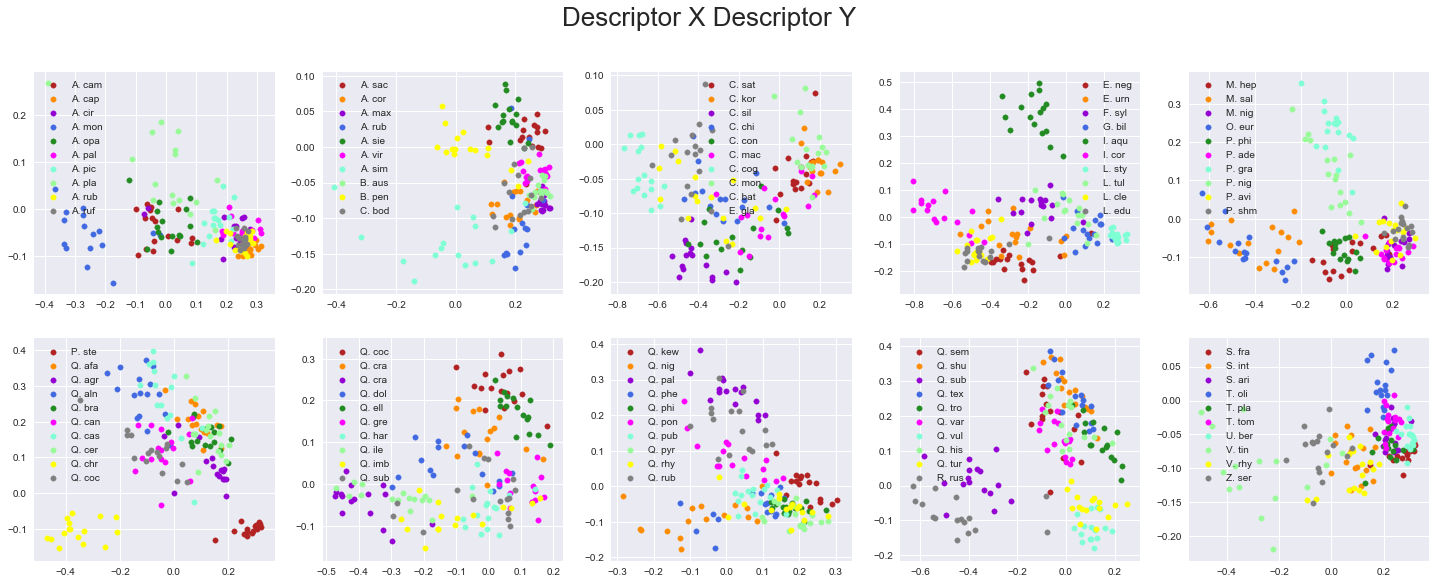

In [54]:
#Plotting the 2-D edge features.
feature_plot(desc_plot, '_')
plt.show()
plt.close()

### 3). Extract perimeters and sizes of the leaves from binary images.

In [307]:
#Binarize the original images and extract the perimeters and sizes of the leaves.
peri = []
size = []
for d in folders:
    for jpg_f in collect_fnames(data_root+d, '.jpg'):
        ori_image = io.imread(data_root+d+'/'+jpg_f)
        #generate a binary image for perimeter calculation.
        thresh = filters.threshold_otsu(ori_image)
        binary_image = ori_image > thresh
        #get the perimeter value.
        perimet = measure.perimeter(binary_image, neighbourhood=4)
        #sum the True values in the boolean binary image.
        size = binary_image.sum()
        peri.append(np.hstack(([d], [perimet], [size])))

In [311]:
df_ps = pd.DataFrame(peri, columns=['species', 'peri', 'size'])
print(df_ps.describe())
print(df_ps.head(2))

            species                peri    size
count          1600                1600    1600
unique          100                1598    1365
top     Acer_Opalus  1491.9595949289333  131116
freq             16                   2       6
          species               peri    size
0  Acer_Campestre  3017.627775935468  197657
1  Acer_Campestre  2213.672365088641  130187


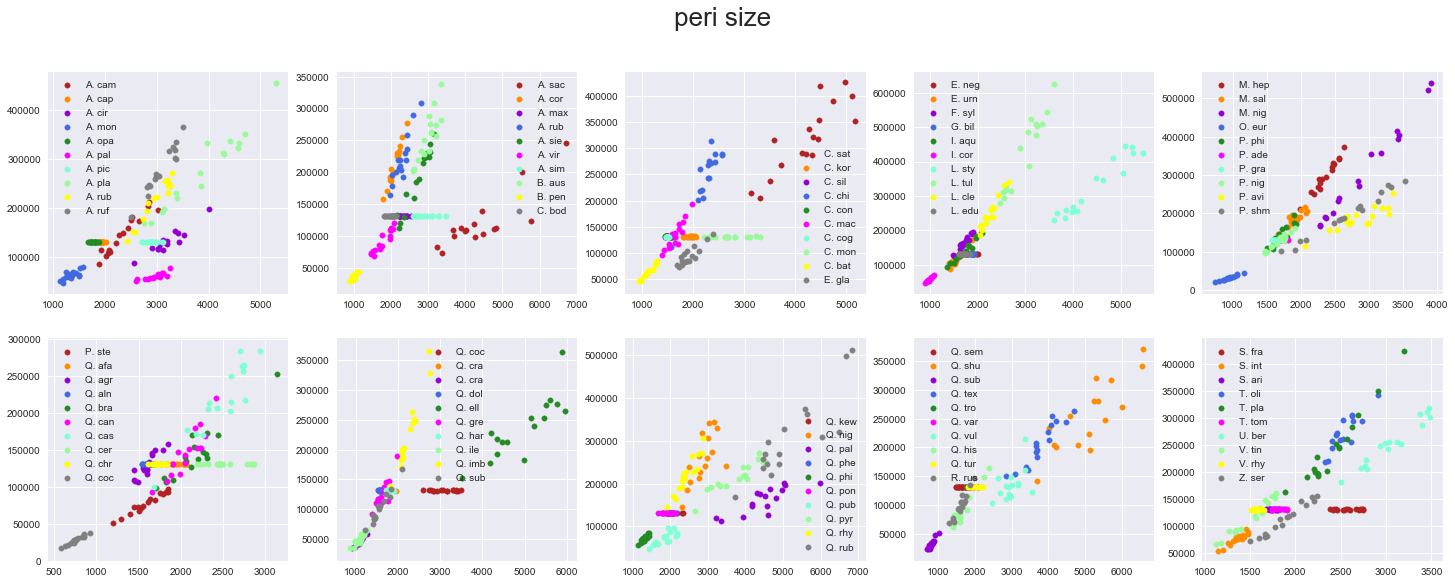

In [312]:
#Plotting the perimeters and sizes.
feature_plot(df_ps, '_')
plt.show()
plt.close()

## Summary of the datasets:
### Each of the pre-extracted features contains 64 feature vectors. They were derived from K-Means dimension reduction and used for classification in a published paper. The texture file somehow had one line missing. I added one line of mean values to fix that. All the three files containing pre-extraced features should be good for machine learning directly without furhter processing. Indeed 2-D plotting for these features suggest that the plant species are reasonably separated. 
### I extracted features from the black and white images of leaves and tested the possibility of using these features to classify species by plotting the features in 2-D spaces. Every ten species were plotted in one panel. The species seem to be partially separated by the 2-D canny edge features, ORB descriptors, perimeters and sizes. 
### The canny edge features and ORB descriptors are very high-dimension features.They will be subjected to dimension reduction. 
### All the features, especially the perimeters and sizes, will be scaled before I put them into machine learning algorithms. 

----

### Try dimension reduction with PCA for the edge features and ORB descriptors.

In [62]:
#A function to plot a scree plot of Explained Variance Ratio from PCA.
def scree_plot(exp_var_ratio, n_pca_components):
    plt.figure(figsize=(5,4))
    plt.plot([i for i in range(1, n_pca_components+1)], exp_var_ratio, 'b-')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Scree Plot')
    plt.show()

In [93]:
#Define the canny edge features.
X_cedge = df_cedge.ix[:, 'cedge1':'cedge13800']

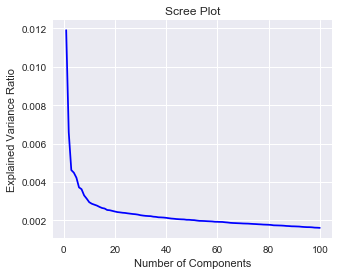

In [81]:
#Dimension reduction with components=100 in PCA.
pca = PCA(n_components=100, copy=True, whiten=True, 
          svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
pca.fit(X_cedge)
#scree plot
scree_plot(pca.explained_variance_ratio_, 100)

In [94]:
#Define the ORB descriptor features.
X_desc = df_desc.ix[:, 'desc1':'desc25600']

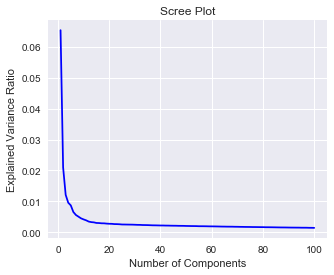

In [80]:
pca = PCA(n_components=100, copy=True, whiten=True, 
          svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
pca.fit(X_desc)
scree_plot(pca.explained_variance_ratio_, 100)

### Now, do dimension reduction using the "best" component number.

In [313]:
# pca = PCA(n_components=20, copy=True, whiten=True, 
#           svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
# mds = MDS(n_components=20, metric=True, 
#           n_init=4, max_iter=300, verbose=0, 
#           eps=0.001, n_jobs=1, random_state=None, 
#           dissimilarity='euclidean')
f_ica = FastICA(n_components=8, algorithm='parallel', whiten=True, fun='logcosh', 
                fun_args=None, max_iter=200, tol=0.0001, w_init=None, random_state=None)
# k_pca = KernelPCA(n_components=20, kernel='poly', gamma=None, degree=4, coef0=1, 
#                   kernel_params=None, alpha=1.0, fit_inverse_transform=False, 
#                   eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False, 
#                   random_state=None, copy_X=True, n_jobs=1)
X_cedge_r = f_ica.fit_transform(X_cedge)
X_desc_r = f_ica.fit_transform(X_desc)

In [314]:
# Data preprocessing
X_cedge_s = scale(X_cedge_r)
X_desc_s = scale(X_desc_r)
X_ps_s = scale(df_ps[['peri','size']])
X_sha_s = scale(df_sha.ix[:, 'sha1':'sha64'])
X_mar_s = scale(df_mar.ix[:, 'mar1':'mar64'])
X_texf_s = scale(df_texf.ix[:, 'tex1':'tex64'])

### Test machine learning algorithms.

In [315]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

In [316]:
#Make species labels as y.
le = LabelEncoder().fit(df_cedge_new.cedge0)
y = le.transform(df_cedge_new.cedge0)
y

array([ 0,  0,  0, ..., 99, 99, 99])

In [317]:
skf = StratifiedKFold(n_splits=4, random_state=2, shuffle=True)

In [318]:
#svm to test each pre-extracted features.
params2 = {'kernel':['rbf','linear'],
           'C':[0.1, 0.2, 0.3, 0.4, 0.5]}
gs2 = GridSearchCV(estimator=SVC(),param_grid=params2,cv=skf,scoring='accuracy')
mod2 = gs2.fit(X_sha_s, y)
print(pd.DataFrame(mod2.cv_results_))
print(mod2.best_estimator_)
print('\n',mod2.best_score_)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0       0.370518         0.113438         0.481875          0.542708     0.1   
1       0.128355         0.104543         0.583125          0.686250     0.1   
2       0.300586         0.104082         0.483125          0.542917     0.2   
3       0.112801         0.087750         0.638750          0.762292     0.2   
4       0.266319         0.103480         0.485000          0.545417     0.3   
5       0.111496         0.088921         0.651250          0.801458     0.3   
6       0.257189         0.102927         0.486875          0.548750     0.4   
7       0.110635         0.086299         0.672500          0.828958     0.4   
8       0.235022         0.103488         0.490625          0.553333     0.5   
9       0.111219         0.086421         0.675000          0.847083     0.5   

  param_kernel                          params  rank_test_score  \
0          rbf     {'C': 0.1, 'kernel': 'rbf'}      

In [327]:
#svm to test the combination of pre-extracted shape features 
#and the newly extracted ORB descriptors and canny edge features.
params2 = {'kernel':['rbf','linear'],
           'C':[0.1, 0.2, 0.3, 0.4, 0.5]}
gs2 = GridSearchCV(estimator=SVC(),param_grid=params2,cv=skf,scoring='accuracy')
mod2 = gs2.fit(np.hstack((X_ps_s, X_desc_s, X_sha_s)), y)
print(pd.DataFrame(mod2.cv_results_))
print(mod2.best_estimator_)
print('\n',mod2.best_score_)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0       0.383297         0.108430         0.686250          0.787708     0.1   
1       0.142966         0.095628         0.841250          0.955417     0.1   
2       0.369341         0.115623         0.687500          0.787708     0.2   
3       0.151734         0.102718         0.855000          0.976667     0.2   
4       0.345329         0.119618         0.694375          0.792917     0.3   
5       0.148015         0.095622         0.859375          0.985208     0.3   
6       0.309946         0.117758         0.705625          0.803333     0.4   
7       0.146528         0.100440         0.861250          0.991458     0.4   
8       0.317758         0.118224         0.720000          0.816042     0.5   
9       0.140197         0.093927         0.858750          0.993958     0.5   

  param_kernel                          params  rank_test_score  \
0          rbf     {'C': 0.1, 'kernel': 'rbf'}      

### Adding the ORB descriptors to the pre-extracted shape features increased the accuracy from 0.675 to 0.843. Further adding the perimeters and sizes increased the accuracy to 0.861. Further adding the canny edge features did not increase accuracy.

### I will further try to extract leaf features to enhance the model.
### I will tune the algorithm with new features.